In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

import sys
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.datasets import mnist
from random import randint
# Any results you write to the current directory are saved as output.

C:\Users\I056036\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Descriminator Model Class

In [2]:
class Discriminator(object):
    def __init__(self, width = 28, height = 28, channels = 1, latent_size = 100):
        self.CAPACITY = width*height*channels
        self.SHAPE = ( width, height ,channels )
        self.OPTIMIZER = Adam(lr = 0.0002, decay = 8e-9)
        
        self.Discriminator = self.model()        
        self.Discriminator.compile( loss = 'binary_crossentropy', optimizer = self.OPTIMIZER, metrics = ['accuracy'])
#         self.save_model()
        self.Discriminator.summary()
        
#   Model  Definition 
    def model(self):
        model = Sequential()
        model.add(Flatten(input_shape = self.SHAPE))
        model.add(Dense(self.CAPACITY, input_shape = self.SHAPE))
        model.add(LeakyReLU(alpha = 0.2))

        model.add(Dense(int(self.CAPACITY/2)))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(1, activation= 'sigmoid'))
        return model
    
    def summary(self):
        return self.Discriminator.summary()
    
    def save_model(self):
        plot_model(self.Discriminator.model, to_file = 'Discriminator_Model.png')
        

### Genarator Model Class

In [3]:
class Generator(object):
     def __init__(self, width = 28, height = 28, channels = 1, latent_size = 100):
        self.W = width
        self.H = height
        self.C = channels
        self.OPTIMIZER = Adam(lr = 0.0002, decay = 8e-9)

        self.LATENT_SPACE_SIZE = latent_size

        #Latent Space is normal distribution with mean 0, std deviation 1 and no of samples = LATENT_SPACE_SIZE
        self.latent_space = np.random.normal(0, 1, (self.LATENT_SPACE_SIZE,))

        self.Generator = self.model()
        self.Generator.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER)
#         self.save_model()
        self.summary()
    
     def model(self, block_starting_size = 128, num_blocks = 4):
        model = Sequential()

        block_size = block_starting_size
        model.add(Dense(block_size, input_shape = (self.LATENT_SPACE_SIZE,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
    
#   Add more Dense Layers with increasing nuerons 
        for i in range(num_blocks-1):
            block_size = block_size*2
            model.add(Dense(block_size))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.W * self.H * self.C, activation = 'tanh'))
        model.add(Reshape((self.W,  self.H, self.C)))

        return model

     def summary(self):
            return self.Generator.summary()

     def save_model(self):
        plot_model(self.Generator.model, to_file = 'Generator_Model.png')

### Generative Adversarial model Class

In [4]:
class GAN(object):
    def __init__(self, discriminator, generator):
        self.OPTIMIZER = Adam(lr = 0.0002, decay = 8e-9)
        self.Generator = generator

        self.Discriminator = discriminator
        self.Discriminator.trainable = False

        self.gan_model = self.model()
        self.gan_model.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER)
#         self.save_model()
        self.summary()
    
    def model(self):
        model = Sequential()
        model.add(self.Generator)
        model.add(self.Discriminator)
        return model

    def summary(self):
        return self.gan_model.summary()

    def save_model(self):
        plot_model(self.gan_model, to_file = 'Gan_Model.png')

### Trainer Class

In [5]:

class Trainer:
    def __init__(self, width = 28, height = 28, channels = 1, latent_size = 100, epochs = 50000, 
        batch = 32, checkpoint = 50, model_type = -1):

        self.W = width
        self.H = height
        self.C = channels
        self.EPOCHS = epochs
        self.BATCH =batch
        self.CHECKPOINT  =checkpoint
        self.model_type = model_type

        self.LATENT_SPACE_SIZE = latent_size

        self.generator = Generator(width = self.W, height = self.H, channels =self.C, latent_size = self.LATENT_SPACE_SIZE)
        self.discriminator = Discriminator(width = self.W, height = self.H, channels =self.C)
        self.gan = GAN(discriminator = self.discriminator.Discriminator, generator = self.generator.Generator)

        self.load_MNIST()

    def load_MNIST(self, model_type = 3):
        allowed_types = [-1, 0,1,2,3,4,5,6,7,8,9]
        if self.model_type not in allowed_types:
            print('Error: Integer values from -1 to 9 allowed')

        (self.X_train, self.y_train), (_,_)  = mnist.load_data()

        if self.model_type != -1:
            self.X_train = self.X_train[np.where(self.y_train == int(self.model_type))[0]]

        #      rescale from -1 to 1
        self.X_train = (np.float32(self.X_train) - 127.5) / 127.5
        self.X_train = np.expand_dims(self.X_train, axis = 3)

    def train(self):
        for e in range(self.EPOCHS):
            # First half of data in real, second half is noise gnerated by generator model

            # Prepare  Real data by randomly selecting (equal to half the number of batch size)
            count_real_images = int(self.BATCH/2)
            starting_index = randint(0, (len(self.X_train) - count_real_images))
            real_images_raw = self.X_train[starting_index :(starting_index + count_real_images)]
            x_real_images = real_images_raw.reshape(count_real_images, self.W, self.H, self.C)
            y_real_labels = np.ones([count_real_images, 1])

            #   Prepare the fake generated data
            latent_space_samples = self.sample_latent_space(count_real_images)
            x_generated_images = self.generator.Generator.predict(latent_space_samples)
            y_generated_labels = np.zeros([self.BATCH - count_real_images, 1])

            #       combine the real and fake data to feed on descriminator
            x_batch = np.concatenate([x_real_images, x_generated_images])
            y_batch = np.concatenate([y_real_labels, y_generated_labels])

            #Train the descriminator model
            discriminator_loss = self.discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]

            #Generate Noise
            x_latent_space_samples = self.sample_latent_space(self.BATCH)
            y_generated_labels = np.ones([self.BATCH,1]) 
            generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples, y_generated_labels)            
           
            
            if e % self.CHECKPOINT == 0:
                print('Epoch: {} Discriminator Loss: {:0.6f}, Generator Loss {:0.6f}'.format(e, discriminator_loss, generator_loss))
                self.plot_checkpoint(e)
        
    def sample_latent_space(self, instances):
        return np.random.normal(0, 1, (instances,self.LATENT_SPACE_SIZE))

    def plot_checkpoint(self,e):
        filename = "sample_"+str(e)+".png"

        noise = self.sample_latent_space(16)
        images = self.generator.Generator.predict(noise)

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.H,self.W])            
            plt.imshow(image, cmap='gray')            
            plt.axis('off')
            
        
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()
        plt.close('all')
        return      

### Train the Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
__________

C:\Users\I056036\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 Discriminator Loss: 0.511101, Generator Loss 0.430572


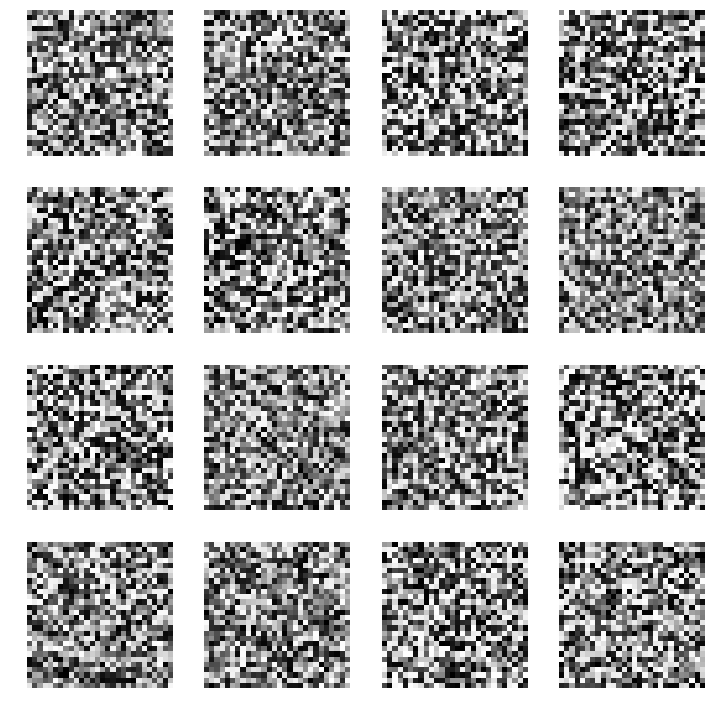

Epoch: 1000 Discriminator Loss: 0.140036, Generator Loss 4.383698


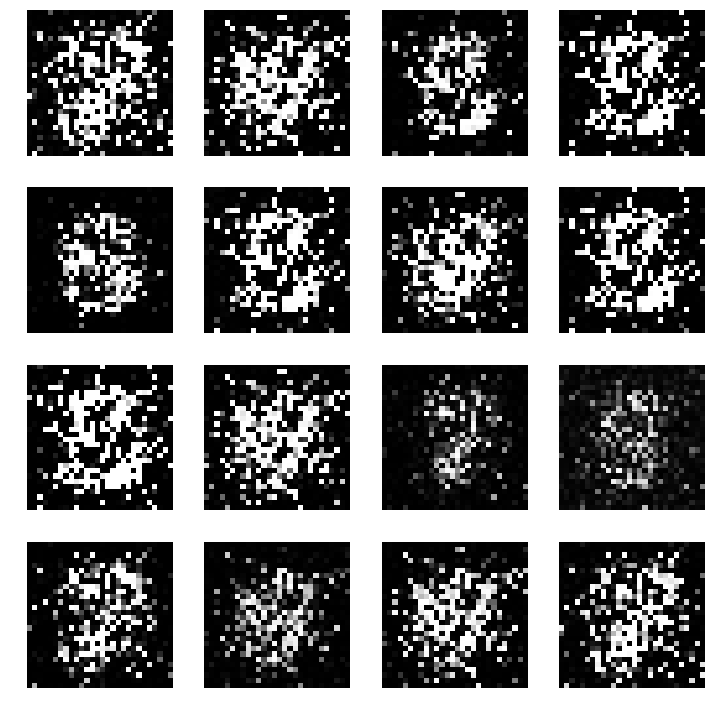

Epoch: 2000 Discriminator Loss: 0.235619, Generator Loss 6.694876


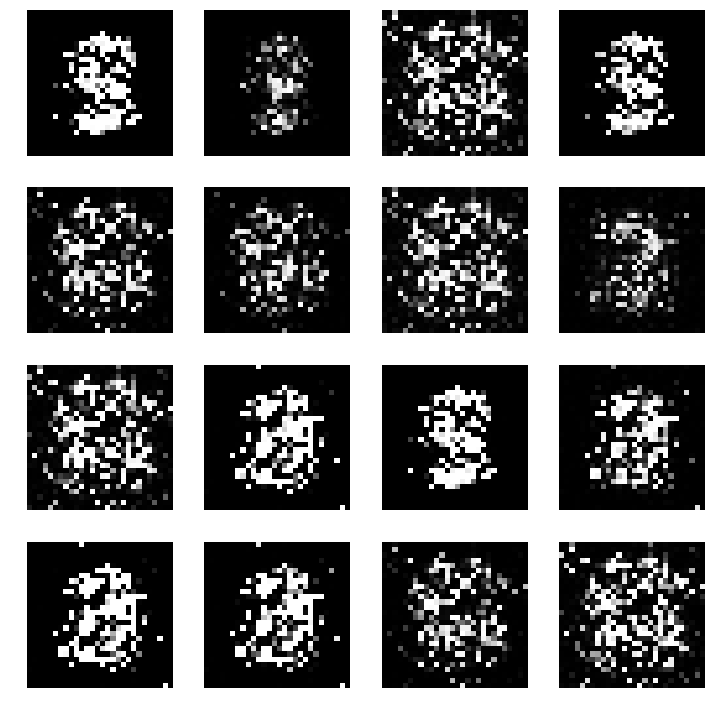

Epoch: 3000 Discriminator Loss: 0.310423, Generator Loss 4.883754


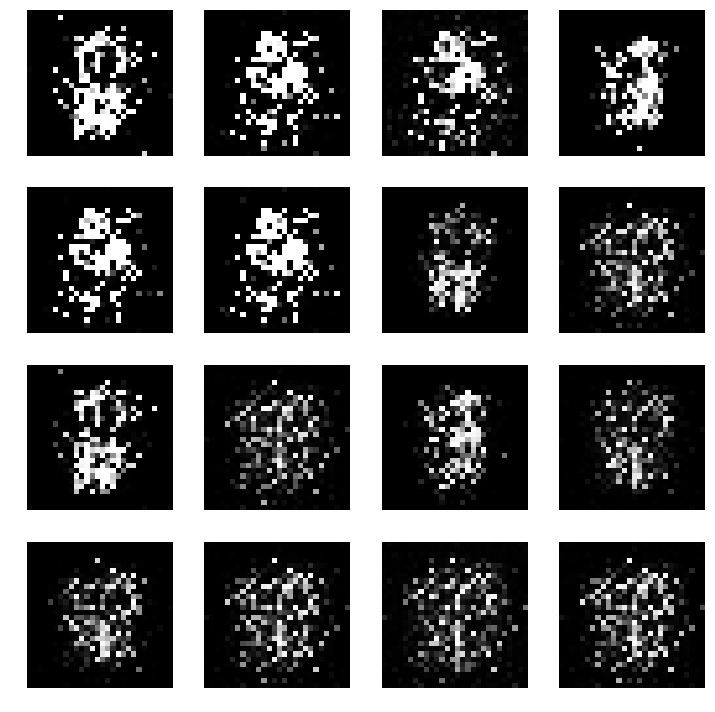

Epoch: 4000 Discriminator Loss: 0.440591, Generator Loss 1.758058


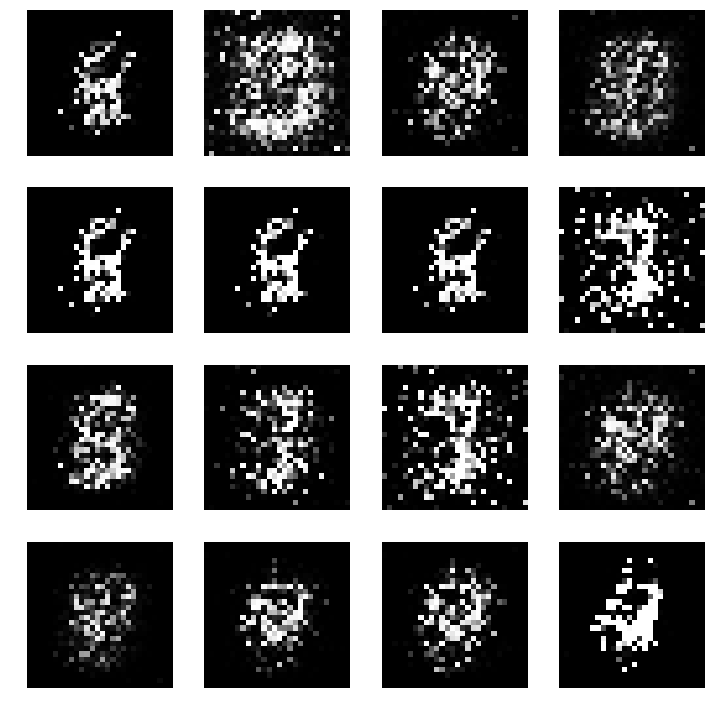

Epoch: 5000 Discriminator Loss: 0.378107, Generator Loss 3.101310


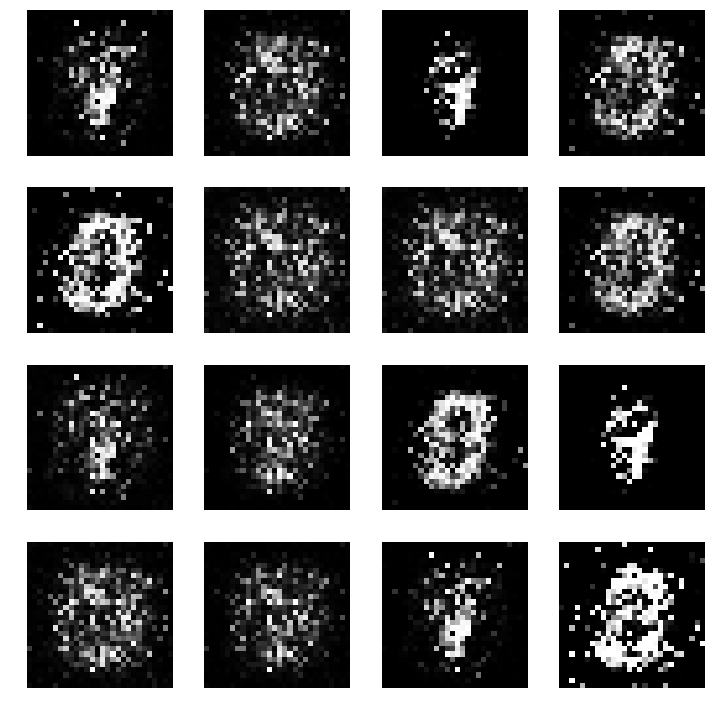

In [ ]:
HEIGHT  = 28
WIDTH   = 28
CHANNEL = 1
LATENT_SPACE_SIZE = 100
EPOCHS = 50001
BATCH = 32
CHECKPOINT = 1000
MODEL_TYPE = -1

trainer = Trainer(height=HEIGHT,\
                 width=WIDTH,\
                 channels=CHANNEL,\
                 latent_size=LATENT_SPACE_SIZE,\
                 epochs =EPOCHS,\
                 batch=BATCH,\
                 checkpoint=CHECKPOINT,
                 model_type=MODEL_TYPE)
                 
trainer.train()

Testing

In [ ]:
#  def sample_latent_space(instances):
#         return np.random.normal(0, 1, (instances,LATENT_SPACE_SIZE))
    
model_type = 4
allowed_types = [-1, 0,1,2,3,4,5,6,7,8,9]
if model_type not in allowed_types:
    print('Error: Integer values from -1 to 9 allowed')

(X_train, y_train), (_,_)  = mnist.load_data()

if model_type != -1:
    X_train = X_train[np.where(y_train == int(model_type))[0]]
    
X_train = (np.float32(X_train) - 127.5) / 127.5
# X_train = np.expand_dims(X_train, axis = 3)    

# count_real_images = int(BATCH/2)
# starting_index = randint(0, (len(X_train) - count_real_images))
# real_images_raw = X_train[starting_index :(starting_index + count_real_images)]
# x_real_images = real_images_raw.reshape(count_real_images, W, H, C)
# y_real_labels = np.ones([count_real_images, 1])

# latent_space_samples = sample_latent_space(count_real_images)  
# generator = Generator(height=H, width=W, channels= C, latent_size= LATENT_SPACE_SIZE)
# x_generated_images = generator.Generator.predict(latent_space_samples)
# y_generated_lables = np.zeros([BATCH - count_real_images, 1])

# x_batch = np.concatenate([x_real_images, x_generated_images])
# y_batch = np.concatenate([y_real_labels, y_generated_lables])

# discriminator = Discriminator(height= H, width= W, channels = C)
# discriminator_loss = discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]

In [ ]:
# image = X_train[700]
# plt.imshow(image, cmap = 'gray')   
# plt.show()
# X_train[700]